# Re-integrate vacc
for scenario_name, scenario in scenarios.items():
    max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
    md = pd.read_csv(f'{outdir}{file_prefix}{scenario_name}-{met}{nnodes}.csv', index_col= 'date', parse_dates=True)# Analysis of optimal scenarios agaisnt other scenarios

In [6]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
outdir = 'model_output/'
when = 'future'
file_prefix = f''
file_prefix = f'rk5'
outdir = 'helvetios-runs/'

n_int_steps = 5
nnodes = 107  # nodes
ndays = 90

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'model_output/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [7]:
scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(29)}

In [10]:
# Choose a subset of scenarios:
pick = '-L-R7.5-'
scenarios = {k:v for (k,v) in scenarios.items() if pick in k}
print(len(scenarios))

4


In [11]:
no_vacc = pd.read_csv(f'{outdir}{file_prefix}FR{pick}T15-int107-nc.csv', index_col= 'date', parse_dates=True)

In [ ]:
scenarios = {k:v for (k,v) in scenarios.items() if '-T5' not in k}

In [12]:
# Generate alternatives:
# BY INCIDENCE: 
incid = no_vacc[no_vacc['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])].groupby('placeID').sum()
incid.sort_values('value', ascending=False)
for scenario_name, scenario in scenarios.items():
    print(scenario_name)
    unvac_nd = np.copy(setup.pop_node)
    max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
    control_initial = np.zeros((M, N))
    allocated_total = 0

    for nd in incid.sort_values('value', ascending=False).index:
        for k in range(N):
            if (allocated_total + max_vacc_rate[nd,k] < vacc_total) and (unvac_nd[nd] - max_vacc_rate[nd,k] > 0):
                control_initial[nd, k] = max_vacc_rate[nd,k]
                allocated_total += max_vacc_rate[nd,k]
                unvac_nd[nd] -= max_vacc_rate[nd,k]
                
    p.apply_epicourse(setup, scenario['beta_mult'])

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-inc{nnodes}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
# BY POPULATION 
for scenario_name, scenario in scenarios.items():
    max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
    control_initial = np.zeros((M, N))
    allocated_total = 0
    unvac_nd = np.copy(setup.pop_node)

    for nd in reversed(np.argsort(setup.pop_node)):
        for k in range(N):
            if (allocated_total + max_vacc_rate[nd, k] < vacc_total) and (unvac_nd[nd] - max_vacc_rate[nd,k] > 0):
                control_initial[nd, k] = max_vacc_rate[nd,k]
                allocated_total += max_vacc_rate[nd,k]
                unvac_nd[nd] -= max_vacc_rate[nd,k]
                
    p.apply_epicourse(setup, scenario['beta_mult'])

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-pop{nnodes}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    


  0%|          | 0/89 [00:00<?, ?it/s]

FR-L-R7.5-T2
===> Integrating for helvetios-runs/rk5FR-L-R7.5-T2-inc107


  0%|          | 0/89 [00:00<?, ?it/s]

FR-L-R7.5-T5
===> Integrating for helvetios-runs/rk5FR-L-R7.5-T5-inc107


  0%|          | 0/89 [00:00<?, ?it/s]

FR-L-R7.5-T10
===> Integrating for helvetios-runs/rk5FR-L-R7.5-T10-inc107


100%|██████████| 89/89 [00:03<00:00, 22.33it/s]


FR-L-R7.5-T15


  2%|▏         | 2/89 [00:00<00:04, 19.14it/s]

===> Integrating for helvetios-runs/rk5FR-L-R7.5-T15-inc107


  3%|▎         | 3/89 [00:00<00:03, 22.09it/s]

===> Integrating for helvetios-runs/rk5FR-L-R7.5-T2-pop107


  3%|▎         | 3/89 [00:00<00:04, 20.42it/s]

===> Integrating for helvetios-runs/rk5FR-L-R7.5-T5-pop107


  3%|▎         | 3/89 [00:00<00:03, 22.54it/s]

===> Integrating for helvetios-runs/rk5FR-L-R7.5-T10-pop107


  3%|▎         | 3/89 [00:00<00:03, 21.58it/s]

===> Integrating for helvetios-runs/rk5FR-L-R7.5-T15-pop107


100%|██████████| 89/89 [00:03<00:00, 22.63it/s]


In [13]:
# Re-integrate vacc
for scenario_name, scenario in scenarios.items():
    max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
    md = pd.read_csv(f'{outdir}{file_prefix}{scenario_name}-opt{nnodes}.csv', index_col= 'date', parse_dates=True)
    control_initial = np.zeros((M, N))
    allocated_total = 0
    unvac_nd = np.copy(setup.pop_node)

    for nodename in md.place.unique():
        mdn = md[(md['place'] == nodename) & (md['comp'] == 'vacc')]
        for date in mdn.index[:-2]:
            nd = setup.ind2name.index(nodename)
            k = list(setup.model_days).index(date)
            #print(date, k)
            #if (allocated_total + max_vacc_rate[nd, k] < vacc_total) and (unvac_nd[nd] - max_vacc_rate[nd,k] > 0):
            control_initial[nd, k] = mdn.loc[date].value
            allocated_total += mdn.loc[date].value
            unvac_nd[nd] -= mdn.loc[date].value
                
    p.apply_epicourse(setup, scenario['beta_mult'])

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-opi{nnodes}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)

  3%|▎         | 3/89 [00:00<00:03, 22.28it/s]

===> Integrating for helvetios-runs/rk5FR-L-R7.5-T2-opi107


  3%|▎         | 3/89 [00:00<00:03, 22.07it/s]

===> Integrating for helvetios-runs/rk5FR-L-R7.5-T5-opi107


  3%|▎         | 3/89 [00:00<00:03, 24.40it/s]

===> Integrating for helvetios-runs/rk5FR-L-R7.5-T10-opi107


  3%|▎         | 3/89 [00:00<00:03, 22.64it/s]

===> Integrating for helvetios-runs/rk5FR-L-R7.5-T15-opi107


100%|██████████| 89/89 [00:03<00:00, 22.63it/s]


In [ ]:
scenarios.keys()

In [19]:
scn_results = pd.DataFrame(columns=['total_vacc', 'method', 'infected'])
methods = ['opi', 'int', 'inc', 'pop', ] # 'opt'
for met in methods:
    for scenario_name, scenario in scenarios.items():
        max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
        md = pd.read_csv(f'{outdir}{file_prefix}{scenario_name}-{met}{nnodes}.csv', index_col= 'date', parse_dates=True)
        infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (md.index == str(setup.end_date))]['value'].sum()
        doses = md[md['comp']=='vacc']['value'].sum()
        scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'total_vacc':[int(vacc_total)],
                                                                      'method': [met],
                                                                      'infected':[infected],
                                                                       'doses': [doses]
                                                                     })])
  md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (md.index == str(setup.end_date))]['value'].sum()                              
baseline_infected = no_vacc[no_vacc['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])]['value'].sum()
scn_results['averted'] = baseline_infected - scn_results['infected']
scn_results['avertedpervacc'] = scn_results['averted']/scn_results['doses']

In [20]:
#scn_results.replace('opt', 'Optimal', inplace=True)
scn_results.replace('opi', 'Optimal', inplace=True)
scn_results.replace('int', 'Uniform', inplace=True)
scn_results.replace('inc', 'Incidence', inplace=True)
scn_results.replace('pop', 'Population', inplace=True)

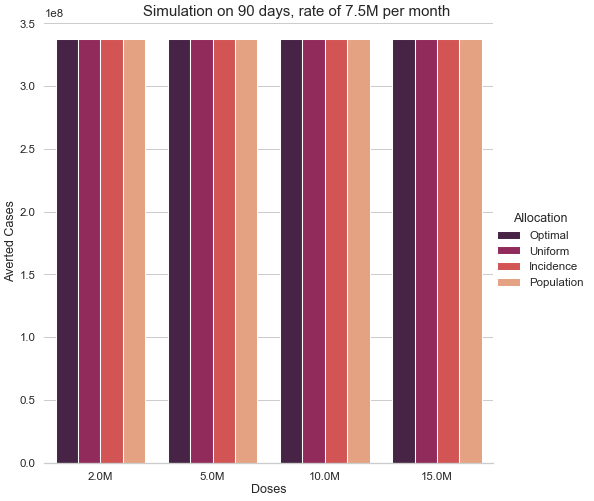

In [21]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':50})
sns.set_theme(style="whitegrid")
sns.set_context("talk")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scn_results, kind="bar",
    x="total_vacc", 
    #y="avertedpervacc", 
    y="averted",
    hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Doses", "Averted Cases")
g.legend.set_title("Allocation")
g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])

In [ ]:
g = sns.lineplot(
    data=scn_results, 
    x="total_vacc", y="averted", hue="method",
    palette="rocket", marker = 'o', 
    #alpha=.9, 
)

In [ ]:
g = sns.catplot(
    data=scn_results, kind="point",
    x="total_vacc", y="averted", hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.set_axis_labels("", "Averted Cases")
g.legend.set_title("Allocation")
g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])